In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes, load_iris
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import levene, ttest_ind, f_oneway, kruskal, shapiro, kstest
import statsmodels.api as sm

### 1. Variable Types in Statistics

Variables are classified based on their scale of measurement and not based on what values they take. For example, Gender can be expressed as Male/Female or 0/1 where 0 represents Male and 1 represents Female. However, we won't say that the variable is numeric even if it's taking values in {0, 1} since they don't have a numeric meaning and are non-quantifiable. The measurement scale for variable is Nominal scale and so the variable type is Nominal. 

There are multiple ways to classify variables:

1. Classification based on whether they are quantifiable or non-quantifiable:
    1. **Categorical (Qualitative) Variables:** Variables that do not have a numeric meaning.
        1. **Nominal:** No order among categories. For example - Male/Female. 
        2. **Ordinal:** Order among categories. For example - Ratings from 1 to 5.
    2. **Numeric (Quantitative) Variables:** Variables that have a numeric meaning.
        1. **Interval:** 
            1. Variables that do not have a true zero (or it's arbitrary), or that zero value of that variable doesn't make sense. For example - IQ. Zero IQ doesn't mean anything. At the same time, person with IQ of 100 does not mean being twice as sharp to person with IQ of 50.
            2. These variables have equal distance between values. 
        2. **Ratio/Count:** 
            1. Variables where zero value makes sense. For example - number of apples, 0 apples means nothing, while having 10 apples mean having twice as many as having 5 apples.
            2. These variables have an intrinsic order with equal distance between values, howsoever small.
               
2. Classification based on whether they are continuous or discrete:
    1. **Discrete:** 
        1. If discrete and numeric, the variable can take a finite set of values in a given interval. Example - 
        2. If discrete and categorical, the variable can take a finite set of choices  
        3. All categorical variables are discrete in nature.
        4. Numeric variables can be discrete in nature.
    2. **Continuous:** 
        1. Continuous variables are always numeric.
        2. If continuous and interval, the variable can take infinite set of values in a given interval but not meaningful zero.  
        3. If continuous and ratio, the variable can take infinite set of values in a given interval but meaningful zero.


**Informal Rules:**
1. Ordinal: Nominal + Order
2. Interval: Order + Equal distance between values
3. Ratio: Interval + True Zero

In [2]:
significance_level = 0.05

In [3]:
dataset = load_diabetes()
df = pd.DataFrame(dataset['data'], columns = dataset['feature_names'])
df['target'] = dataset['target']
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


#### Statistical Testing

Here are a few tests for various data types: 

1. Categorical v/s Numerical:
    1. Check for Homogeneity of variances: F-Test (Two groups) / Levene Test (Two or more groups)
        1. Two categories:
            1. If samples coming from populations with similar variances:
                1. Pooled T-Test
            2. Else:
                1. Welch T-Test
        2. More than two categories:
            1. If samples coming from populations with similar variances:
                1. One-Way ANOVA (assumes that variances are equal)
            2. Else:
                1. Welch ANOVA
                2. Kruskal-Wallis Test: Tests whether medians are equal
                3. One-way ANOVA:
                    1. If max_variance / min_variance < 4 (thumb rule)
                    2. Sample sizes are equal

2. Categorical v/s Categorical:
    1. Build a contingency table (crosstab) of frequencies across all combinations of categories
        1. If frequencies are above 5:
            1. Pearson's Chi-Square Test for goodness of fit
        2. Else:
            1. Fisher's Exact Test

3. Numerical v/s Numerical:
    1. Pearson Correlation
    2. R2, adjusted R2
    3. Hypothesis Testing:
        1. Types:
            1. Test of equality of proportions:
                1. Z-Test
            2. Test of equality of means:
                1. If standard deviation is known:
                    1. Z-Test     
                2. If standard deviation is unknown:
                    1. If samples coming from populations with similar variances:
                        1. Pooled T-Test
                    2. Else:
                        1. Welch T-Test            
            3. Test of equality of variances:
                1. F-Test
            
4. Tests of equality of distributions:
    1. Kolmogorov-Smirnov Test (KS-Test) of goodness of fit
    2. Q-Q plots
    3. Shapiro-Wilk Test for normality

5. Other tests:
    1. Paired t-test
    2. Wilcoxon signed-rank test
    3. Sign test    

### Check variation in gender

Let's do a statistical test to understand whether there is significant difference in target value with respect to gender.

In [4]:
print('Number of unique values:', df['sex'].nunique())
vals = df['sex'].unique().tolist()

target_vals_1 = df.loc[df['sex']==vals[0], 'target'].values
target_vals_2 = df.loc[df['sex']==vals[1], 'target'].values
print('Sample Sizes: ', len(target_vals_1), len(target_vals_2))

Number of unique values: 2
Sample Sizes:  207 235


### Normality criteria for T-Test

As Student's t-statistic with $n$ degrees of freedom is a ratio of Normal to Chi-Square distribution with $n$ degrees of freedom, t-test has some normality criteria that needs to be followed.

According to **Central Limit Theorem (CLT)**: 
1. If sample size (N) > 30:
    1. Sample mean follows normal distribution regardless of whether sample comes from normal distribution or not
2. Else:
    1. If sample comes from normal distribution:
        1. Sample mean follows normal distribution
    2. Else:
        1. Sample mean **doesn't follow normal distribution**

Hence, except in case where the **sample size is small** and **sample is not coming from normal distribution**, t-test can be performed regardless of what distribution the variable follows.   

In our case, we have enough sample size to perform a t-test.

In [5]:
def ttest(*args, **kwargs):
    center = kwargs['center']
    significance_level = kwargs['significance_level']
    
    # check homogeneity of variances
    # center represents appropriate function to use for test
    t_stat, p_value = levene(*args, center=center)
    if p_value < significance_level:
        # null hypothesis rejected 
        # samples coming from populations with different variances
        # Welch t-test
        print('Unequal variances')
        t_stat, p_value = ttest_ind(*args, equal_var=False)
    else:
        # null hypothesis failed to reject
        # samples coming from populations with similar variances
        # Pooled t-test
        print('Equal variances')
        t_stat, p_value = ttest_ind(*args, equal_var=True)
    return p_value

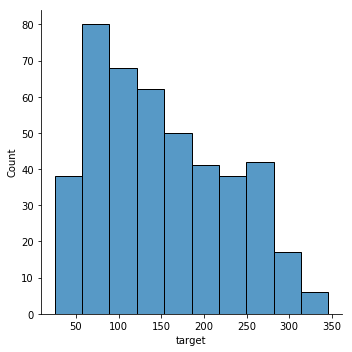

Equal variances

p-value:  0.3664292946519826
Conclusion: Insignificant variation among genders


In [6]:
sns.displot(df['target'])
plt.show()

# center - appropriate function as per data distribution
p_value = ttest(target_vals_1, target_vals_2, center = 'mean', significance_level = 0.05)

print('\np-value: ', p_value)
if p_value < significance_level:
    # null hypothesis rejected 
    # means are statistically different
    print('Conclusion: Significant variation among genders')
else:
    # null hypothesis failed to reject 
    # means are not statistically different
    print('Conclusion: Insignificant variation among genders')

### Check variation in Sepal Width among various iris species

Let's do a statistical test to understand whether there is significant difference in sepal widths with respect to iris species. There are 3 classes and so we need to do ANOVA test, or pairwise t-tests which take inputs from 2 classes.

In [7]:
dataset = load_iris()
df = pd.DataFrame(dataset['data'], columns = dataset['feature_names'])
df['target'] = dataset['target']
print('Data Shape:', df.shape)
df.head(3)

Data Shape: (150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


### Test for Normality: 
1. **Shapiro Wilk Test:**
    1. Tests the Null hypothesis that data is normally distributed.
2. **Quantile-Quantile plot:** 
    1. Plots data quantiles against theoretical quantiles.
    2. It also highlights the skewness of distribution. If data quantiles are higher than theoretical quantiles i.e., the Q-Q plot lies above the Y=X line, the data is positively and right-skewed. Else, otherwise.
    3. If there is deviation from Y=X line while considering normal as theoretical distribution, that means the variable is not-normal.
3. **Kolmogorov-Smirnov Test:**
    1. Test for comparing distributions
    2. It can be used to check normality by comparing with normal distribution
    3. Max value of 1

In [8]:
vals = df['sepal width (cm)'].values

t_stat, p_value = shapiro(vals)
print('P-Value:', p_value)
if p_value < significance_level:
    # null hypothesis rejected
    print('Variable does not follow normal distribution')
else:
    # null hypothesis failed to reject
    print('Variable follows normal distribution')

P-Value: 0.10113201290369034
Variable follows normal distribution


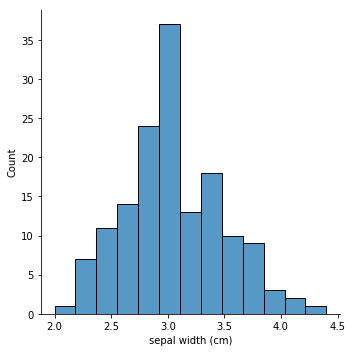

In [9]:
sns.displot(df['sepal width (cm)'])
plt.show()

Skewness: 0.31576710633893473


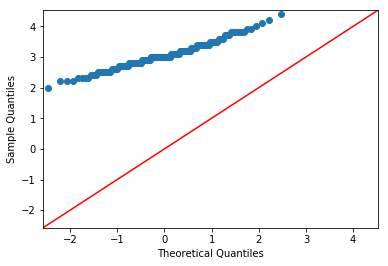

In [10]:
print('Skewness:', stats.skew(vals))
sm.qqplot(vals, dist=stats.norm, line='45')
plt.show()

In [11]:
def anova(*args, **kwargs):
    center = kwargs['center']
    significance_level = kwargs['significance_level']
    
    # check homogeneity of variances
    t_stat, p_value = levene(*args, center=center)
    if p_value < significance_level:
        # null hypothesis rejected 
        # samples coming from populations with different variances
        print('Unequal variances')
        # Kruskal-Wallis Test
        t_stat, p_value = kruskal(*args)
    else:
        # null hypothesis failed to reject
        # samples coming from populations with similar variances
        # One-way ANOVA
        print('Equal variances')
        t_stat, p_value = f_oneway(*args)
    return p_value

In [12]:
print('Number of unique values:', df['target'].nunique())
vals = df['target'].unique().tolist()

target_vals_1 = df.loc[df['target']==vals[0], 'sepal width (cm)'].values
target_vals_2 = df.loc[df['target']==vals[1], 'sepal width (cm)'].values
target_vals_3 = df.loc[df['target']==vals[2], 'sepal width (cm)'].values

p_value = anova(target_vals_1, target_vals_2, target_vals_3, center='mean', significance_level=0.05)
print('\np-value: ', p_value)
if p_value < significance_level:
    # null hypothesis rejected
    # means are statistically different 
    print('Conclusion: Significant variation among plant species')
else:
    # null hypothesis failed to reject
    # means aren't statistically different 
    print('Conclusion: Insignificant variation among plant species') 

Number of unique values: 3
Equal variances

p-value:  4.492017133309115e-17
Conclusion: Significant variation among plant species


#### Quantifying non-normality

A normal distribution is symmetric, unimodal and asymptotic. Any deviation from these three distribution aspects will make the distribution non-normal. One of the properties of normal distribution is that 68% values lies within a standard deviation from mean. This property is followed by a skewed normal but not by multi-modal distribution. However, a skewed normal is also not a normal distribution.

Non-normality can be quantified with skewness and kurtosis of distribution. However, from a sample, you can estimate sample skewness or sample kurtosis just like sample mean or sample variance. To obtain skewness of a distribution, you need to have a distribution in consideration i.e.., you fit a distribution on sample, get MLE estimates and sample from that distribution and calculate skewness. This value will become more accurate as you increase the sample size.

Normal Distribution: 0.68
Skewed Normal Distribution: 0.686
Multi-Modal Distribution: 0.574


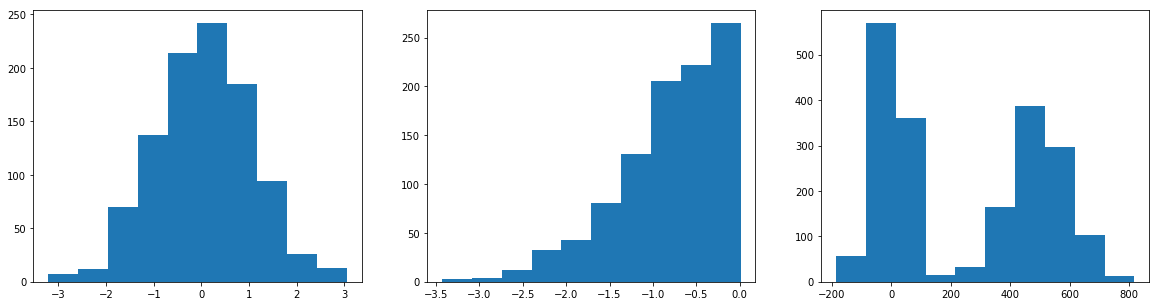

In [13]:
def check_perc_within_1std(sample):
    left = np.mean(sample) - np.std(sample)
    right = np.mean(sample) + np.std(sample)
    return np.mean((sample >= left) & (sample <= right))

plt.figure(figsize=(20, 5))

sample_size = 1000
sample = stats.norm(0, 1).rvs(sample_size)
print('Normal Distribution:', check_perc_within_1std(sample))
plt.subplot(131)
plt.hist(sample)

skew_parameter = -100
sample = stats.skewnorm(skew_parameter).rvs(sample_size)
print('Skewed Normal Distribution:', check_perc_within_1std(sample))
plt.subplot(132)
plt.hist(sample)

X1 = np.random.normal(0, 50, 1000)
X2 = np.random.normal(500, 100, 1000)
sample = np.concatenate((X1, X2))
print('Multi-Modal Distribution:', check_perc_within_1std(sample))
plt.subplot(133)
plt.hist(sample)
plt.show()

### Shapiro Test v/s Q-Q plot
As we increase the sample size, deviation from normality becomes more pronounced. This can be noticed through decreasing p-values of test, while it's hard to notice this through Q-Q plots. In the following example, we consider a slightly skewed normal with different sample sizes.

P-Values: 0.8782455325126648 0.03242142125964165 7.567659849883057e-06


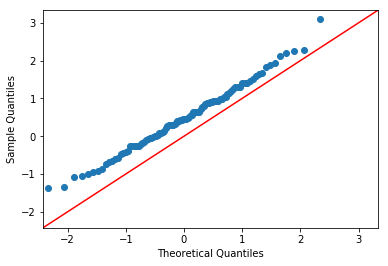

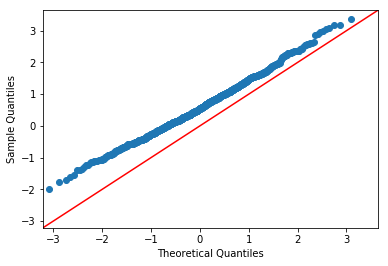

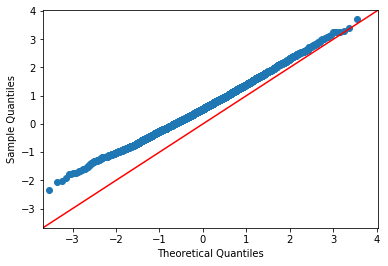

In [14]:
X1 = stats.skewnorm(1).rvs(100)
X2 = stats.skewnorm(1).rvs(1000)
X3 = stats.skewnorm(1).rvs(5000)

_, p_value1 = shapiro(X1)
_, p_value2 = shapiro(X2)
_, p_value3 = shapiro(X3)
print('P-Values:', p_value1, p_value2, p_value3)

sm.qqplot(X1, dist=stats.norm, line='45')
sm.qqplot(X2, dist=stats.norm, line='45')
sm.qqplot(X3, dist=stats.norm, line='45')
plt.show()

### Implementing PDF, CDF and Q-Q Plots

For continuous variables:
1. **PDF:** Probability Density Function
2. **CDF:** Cumulative Density Function
3. **Q-Q Plot:** Quantile-Quantile Plot

In [15]:
def N(x, mu, sigma):
    px = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-np.square(x-mu) / (2 * np.square(sigma)))
    return px

def get_pdf(mu, sigma):
    left = mu - 5 * sigma
    right = mu + 5 * sigma    
    X = np.arange(left, right, 0.001)
    pdf = list(map(lambda x: N(x, mu, sigma), X))
    return plt.plot(X, pdf)
    
def get_cdf(mu, sigma):
    X = np.random.normal(mu, sigma, 10000)
    cdf = []
    for x in X:
        p = np.sum(X <= x) / len(X)
        cdf.append(p)
    return plt.scatter(X, cdf)

def get_Q_Q_plot(mu, sigma):
    X = np.random.normal(mu, sigma, 10000)
    Q = np.arange(0,1,0.001)
    cdf = []
    for q in Q:
        p = np.sum(X <= q) / len(X)
        cdf.append(p)
    return plt.plot(Q, cdf)

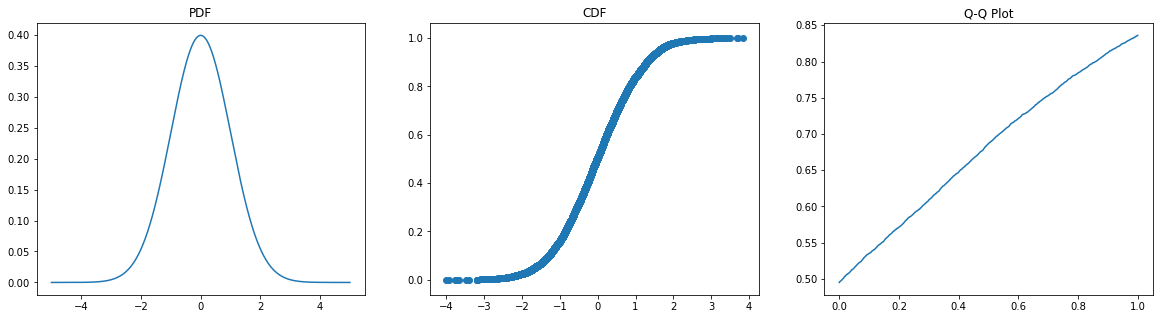

In [16]:
mu = 0
sigma = 1

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('PDF')
get_pdf(mu, sigma)

plt.subplot(132)
plt.title('CDF')
get_cdf(mu, sigma)

plt.subplot(133)
plt.title('Q-Q Plot')
get_Q_Q_plot(mu, sigma)
plt.show()

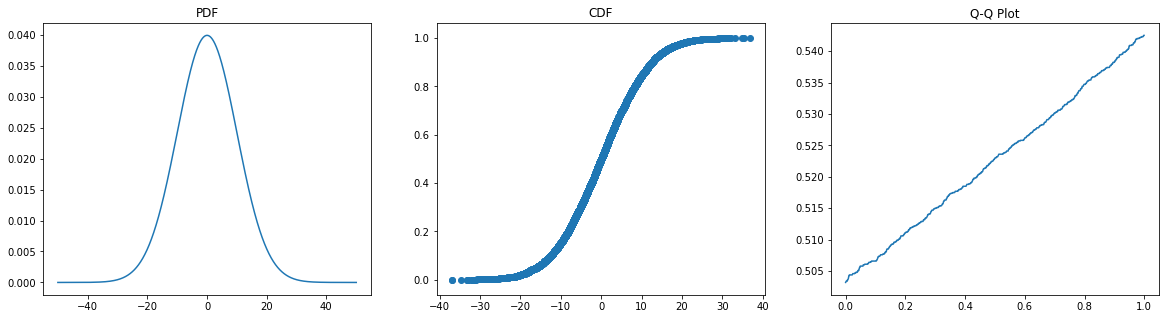

In [17]:
mu = 0
sigma = 10

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('PDF')
get_pdf(mu, sigma)

plt.subplot(132)
plt.title('CDF')
get_cdf(mu, sigma)

plt.subplot(133)
plt.title('Q-Q Plot')
get_Q_Q_plot(mu, sigma)
plt.show()

### Central Limit Theorem

CLT says that sample mean of independently & identically distributed random variables follows normal distribution: 
1. If sample size is large, regardless of whether IID variables follow normal distribution 
2. If sample size is small, if IID variables also follow normal distribution

When sample size is small and variables do not follow normal distribution, sample mean will also not follow normal distribution.

In [18]:
population_size = 100000
sample_size = 1000
n_samples = 1000
data = np.random.gamma(shape=1, scale=1, size=population_size)
sample_means = np.array(list(map(lambda x: np.mean(np.random.choice(data, sample_size)), range(n_samples))))

In [19]:
# Shapiro-Wilk Test
t_stat, p_value = shapiro(sample_means)
print('Performing Shapiro-Wilk Test..')
print('P-Value:', p_value)
if p_value < significance_level:
    # null hypothesis rejected
    print('Variable does not follow normal distribution')
else:
    # null hypothesis failed to reject
    print('Variable follows normal distribution')

# KS - Test
X = np.random.normal(0, 1, 10000)
cdf = []
for x in X:
    p = np.sum(X <= x) / len(X)
    cdf.append(p)

t_stat, p_value = kstest(sample_means, cdf) 
print('\nPerforming Kolmogorov-Smirnov Test..')
print('P-Value:', p_value)
if p_value < significance_level:
    # null hypothesis rejected
    print('Variable does not follow normal distribution')
else:
    # null hypothesis failed to reject
    print('Variable follows normal distribution')   

Performing Shapiro-Wilk Test..
P-Value: 0.0066070519387722015
Variable does not follow normal distribution

Performing Kolmogorov-Smirnov Test..
P-Value: 0.15394740142997732
Variable follows normal distribution


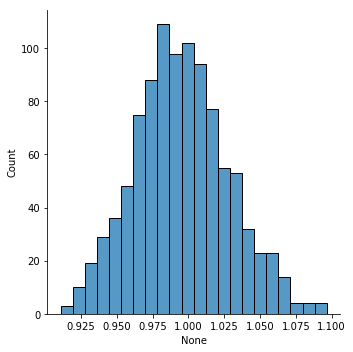

In [20]:
sns.displot(sample_means)
plt.show()